# Clustering encoded vectors and baseline

In [1]:
import os
import csv

import random
import numpy as np

from sklearn.manifold.t_sne import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
f = open('outdir.txt', 'r')
outdir = f.read().rstrip('\n')
f = open('experiment_folder.txt', 'r')
experiment_folder = f.read().rstrip('\n')

##Read encoded vectors file and ordered medical record numbers
with open(experiment_folder + '/encoded_vect.csv') as f:
    rd = csv.reader(f)
    encoded_vect = []
    for r in rd:
        encoded_vect.append(list(map(float, r)))
        
with open(experiment_folder + '/mrns.csv') as f:
    rd = csv.reader(f)
    mrns = []
    for r in rd:
        mrns.append(r[0])
        
# ##Read encoded vectors file and ordered medical record numbers
# with open(experiment_folder + '/LSTMencoded_vect.csv') as f:
#     rd = csv.reader(f)
#     lstm_encoded_vect = []
#     for r in rd:
#         lstm_encoded_vect.append(list(map(float, r)))
        
# with open(experiment_folder + '/LSTMmrns.csv') as f:
#     rd = csv.reader(f)
#     lstm_mrns = []
#     for r in rd:
#         lstm_mrns.append(r[0])

with open(outdir + '/cohort-new_ehr.csv') as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))

##padded raw data from cohort-new_ehr.csv
raw_data = []
max_len = 0
for _, e in raw_ehr.items():
    raw_data.append(e)
    if len(e) >= max_len:
        max_len = len(e)
for idx, s in enumerate(raw_data):
    raw_data[idx] = s + [0]*(max_len-len(s))
    
##get list of first diagnosed diseases associated with mrns
with open(outdir + '/cohort-mrn_diseases.csv') as f:
    rd = csv.reader(f)
    mrn_disease = {}
    for r in rd:
        mrn_disease[r[0]] = r[1::]
        
mrn_encoded_disease = []
for m in mrns:
    mrn_encoded_disease.append(mrn_disease[m][0])

# lstm_mrn_encoded_disease = []
# for m in lstm_mrns:
#     lstm_mrn_encoded_disease.append(mrn_disease[m][0])
    
disease_dict = {}
idx = 0
for d in set(mrn_encoded_disease):
    disease_dict[d] = idx
    idx += 1

mrn_raw_disease = []
for m in raw_ehr:
    mrn_raw_disease.append(mrn_disease[m][0])

with open(outdir + '/cohort-new_vocab.csv') as f:
    rd = csv.reader(f)
    next(rd)
    new_vocab = {}
    for r in rd:
        new_vocab[r[1]] = r[0]
        
len_vocab = len(new_vocab)

>`svd_tfidf()`: returns the SVD matrix of the TFIDF matrix of the raw ehr data;

>`hclust_ehr()`: performs the hierarchical clustering on input data maximizing the Silhouette Index, it returns the number of clusters and the labels;

>`FreqDict()`: returns the frequencies of the medical terms in ehrs;

>`freq_term()`: returns the cluster and the first n most frequent terms in the cluster, the relative frequency w.r.t the whole dataset is given;

>`single_plot()`: returns a plot of all the clusters;

>`nonoveralp_plot()`: returns N different plots with N the number of clusters.

In [3]:
##Hierarchical clustering function
def hclust_ehr(data, min_cl, max_cl, metric):
    best_silh = 0.0
    for n in range(min_cl,max_cl,1):
        hclust = AgglomerativeClustering(n_clusters=n, 
                                         linkage='complete', 
                                         affinity=metric)
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label)
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = n
            label = tmp_label
    try:
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}".format(n_clust, best_silh))
    except UnboundLocalError:
        hclust = AgglomerativeClustering(n_clusters=min_cl,
                                         linkage='complete',
                                         affinity=metric)
        n_clust = min_cl
        label = hclust.fit_predict(data).tolist()
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}".format(n_clust, best_silh))
    return n_clust, label

def svd_tfidf(data, len_vocab):
    
    count_mat = np.zeros((len(data), len_vocab))
    
    for idx, token_list in enumerate(data):
        for t in token_list:
            if t != 0: ##we start the vocabulary from 1
                count_mat[idx, t-1] += 1
                
    tfidf = TfidfTransformer()
    tfidf_mat = tfidf.fit_transform(count_mat)
    
    svd = TruncatedSVD(n_components=32)
    svd_mat = svd.fit_transform(tfidf_mat)
    
    return svd_mat

def FreqDict(tokens):
    freq_dict = {}
    for seq in tokens:
        for s in seq:
            if s not in freq_dict:
                freq_dict[s] = 1
            else:
                freq_dict[s] += 1
    return freq_dict

def freq_term(data, n_clusters, pred_class, n, term_list):
    encoded_groups = OrderedDict()
    encoded_seq = OrderedDict()
    for i in range(n_clusters):
        encoded_groups[i] = []
        encoded_seq[i] = []
        for j in range(len(pred_class)):
            if pred_class[j] == i:
                encoded_groups[i] += [mrns[j]]
                encoded_seq[i].append([rd for rd in data[j] if rd!=0 and (str.split(new_vocab[str(rd)], "::")[0] in term_list)])
                
    for cl in range(n_clusters):
        print("Cluster {0} numerosity: {1}".format(cl, len(encoded_groups[cl])))
        encoded_count = FreqDict(encoded_seq[cl])
        for l in range(n):
            try:
                MFMT = max(encoded_count, key=(lambda key: encoded_count[key]))
                num_MFMT = 0
                for el in data:
                    for t in el:
                        if t == MFMT:
                            num_MFMT += 1
    
                print("Cluster {0} -- Relative numerosity of first most frequent term:{1} = {2:.2f} (count {3})".format(cl,new_vocab[str(MFMT)], 
                                                                                                encoded_count[MFMT]/num_MFMT, encoded_count[MFMT]))
                encoded_count.pop(MFMT)
            except ValueError:
                pass
        print("\n")
        
def single_plot(data, mrn_disease, colors):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j]==cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j]==cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j]==cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x, y, c=cols, label=cl)
    plt.legend()
    
def nonoverlap_plot(data, mrn_disease, colors):
    fig, ax = plt.subplots(len(set(mrn_disease)), 1, figsize=(20, 10*len(set(mrn_disease))))
    for idx, cl in enumerate(set(mrn_disease)):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j]==cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j]==cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j]==cl]
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].scatter(x, y, c=cols, label=cl)
        ax[idx].legend()

In [4]:
##initialize T-SNE
tsne = TSNE(n_components=2, n_iter=5000, perplexity=50, random_state=42)

##colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin']
colormap = [c for c in col_dict if c not in c_out]

In [5]:
# for i, c in enumerate(colormap):
#     print(i, c)

## Clustering CNN+AE encoded vectors

### tSNE with the original classes: **selected diseases** vs **OTH**

In [6]:
##run the TSNE on data
encoded_tsne = tsne.fit_transform(encoded_vect).tolist()

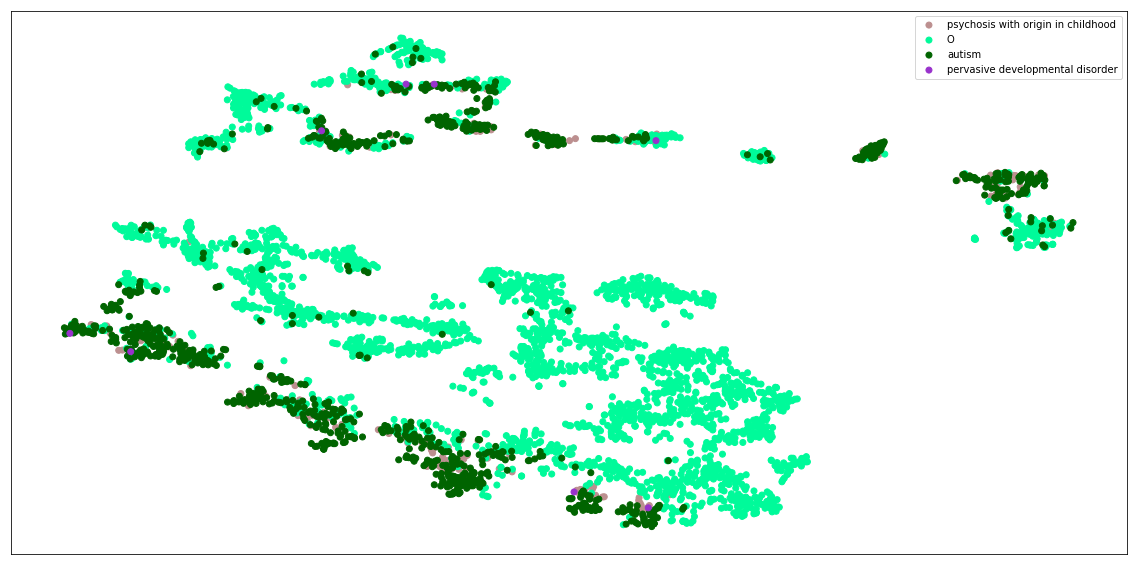

In [7]:
colors_en1 = [colormap[disease_dict[v]] for v in mrn_encoded_disease]
single_plot(encoded_tsne, mrn_encoded_disease, colors_en1)

In [8]:
#nonoverlap_plot(encoded_tsne, mrn_encoded_disease, colors_en1)

In [9]:
##Apply hierarchical clustering to encoded data
n_clust_en, label_en = hclust_ehr(encoded_vect, 9, 40, 'l1')

Number of clusters found:23, Silhouette score:0.195


### tSNE of the cluster found by hierarchical clusters

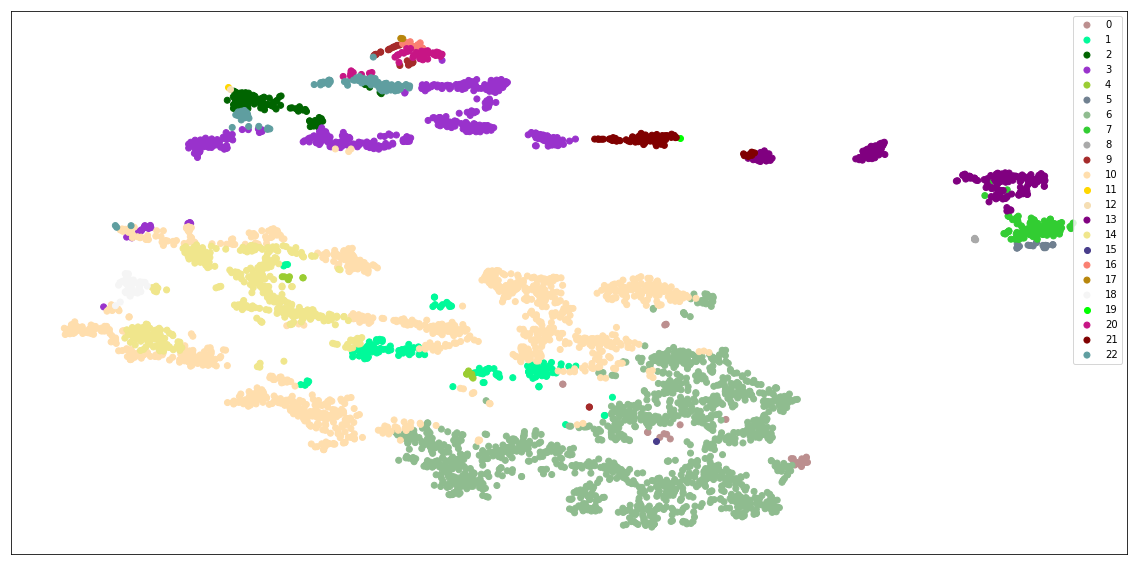

In [10]:
colors_en2 = [colormap[v] for v in label_en]
single_plot(encoded_tsne, label_en, colors_en2)

In [11]:
#nonoverlap_plot(encoded_tsne, label_en, colors_en2)

### Term frequencies inspection

In [12]:
freq_term(raw_data, n_clust_en, label_en, 10, ['icd9', 'medication'])

Cluster 0 numerosity: 27
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.01 (count 31)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.01 (count 23)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.00 (count 22)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Unspecified essential hypertension::401.9::C0085580 = 0.01 (count 20)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Impulse control disorder, unspecified::312.30::C0021122 = 0.03 (count 20)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Abnormality of gait::781.2::C0575081 = 0.04 (count 18)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Contracture of tendon (sheath)::727.81::C0158350 = 0.54 (count 14)
Cluster

## Raw count data

In [6]:
scaler = StandardScaler()
raw_data_counts = np.zeros((len(raw_data), len_vocab))
    
for idx, token_list in enumerate(raw_data):
    for t in token_list:
        if t != 0: ##we start the vocabulary from 1
            raw_data_counts[idx, t-1] += 1
            
raw_data_scaled = scaler.fit_transform(raw_data_counts)

In [18]:
# ##T-SNE
raw_tsne = tsne.fit_transform(raw_data_scaled)

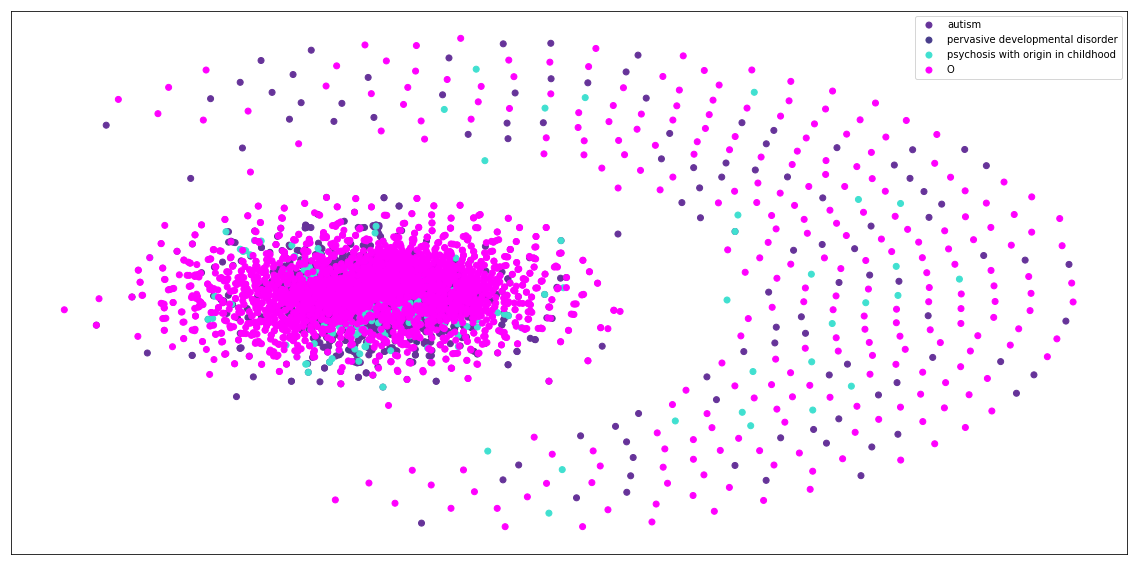

In [19]:
colors_raw1 = [colormap[disease_dict[v]] for v in mrn_raw_disease]
single_plot(raw_tsne, mrn_raw_disease, colors_raw1)

In [20]:
#nonoverlap_plot(raw_tsne, mrn_raw_disease, colors_raw1)

In [7]:
n_clust_raw, label_raw = hclust_ehr(raw_data_scaled, 9, 40, 'cosine')

Number of clusters found:9, Silhouette score:0.000


In [8]:
colors_raw2 = [colormap[v] for v in label_raw]
single_plot(raw_tsne, label_raw, colors_raw2)

NameError: name 'raw_tsne' is not defined

In [15]:
#nonoverlap_plot(raw_tsne, label_raw, colors_raw2)

In [16]:
freq_term(raw_data, n_clust_raw, label_raw, 10, ['icd9', 'medication'])

Cluster 0 numerosity: 202
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.14 (count 663)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.19 (count 399)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.07 (count 278)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Diphenhydramine::3498::C0012522 = 0.16 (count 238)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Impulse control disorder, unspecified::312.30::C0021122 = 0.31 (count 230)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Personal history of allergy to medicinal agents::V14::C0260483 = 0.08 (count 216)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Unspecified pervasive developmental disorder, current o

## Count data

In [21]:
svd_mat = svd_tfidf(raw_data, len_vocab)

In [22]:
# ##T-SNE
count_tsne = tsne.fit_transform(svd_mat)

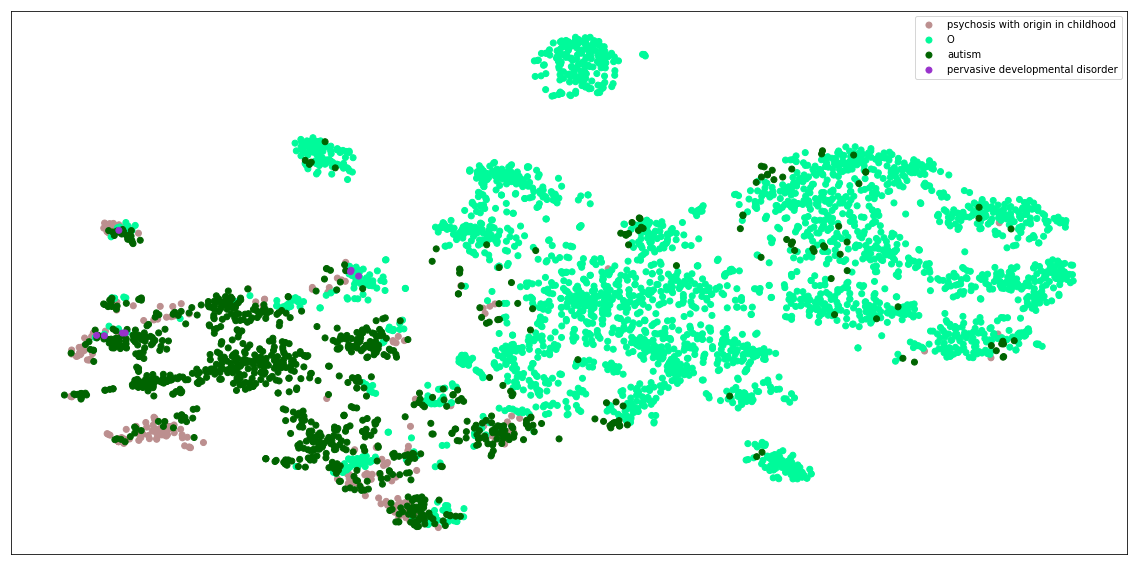

In [23]:
colors_count1 = [colormap[disease_dict[v]] for v in mrn_raw_disease]
single_plot(count_tsne, mrn_raw_disease, colors_count1)

In [24]:
#nonoverlap_plot(count_tsne, mrn_raw_disease, colors_count1)

In [33]:
n_clust_count, label_count = hclust_ehr(svd_mat, 2, 40, 'cosine')

Number of clusters found:2, Silhouette score:0.000


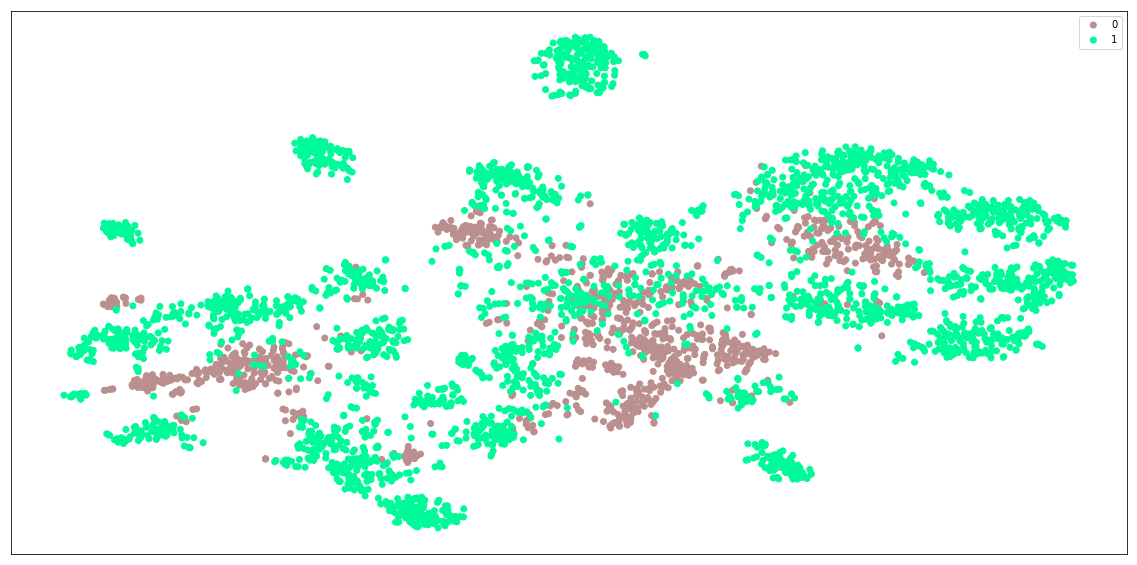

In [34]:
colors_count2 = [colormap[v] for v in label_count]
single_plot(count_tsne, label_count, colors_count2)

In [35]:
#nonoverlap_plot(count_tsne, label_count, colors_count2)

In [36]:
freq_term(raw_data, n_clust_count, label_count, 10, ['icd9', 'medication'])

Cluster 0 numerosity: 1098
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.31 (count 1510)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Ondansetron::26225::C0061851 = 0.25 (count 360)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.17 (count 349)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Oxycodone::7804::C0030049 = 0.22 (count 349)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Personal history of allergy to medicinal agents::V14::C0260483 = 0.13 (count 331)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Cough::786.2::C0010200 = 0.25 (count 329)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Amphetamine::725::C0002658 = 0.73 (count 317)
Cluster 0 -- Relative numerosity of first most frequent ter

## Clustering LSTM encoded vectors

### tSNE with the original classes: **selected diseases** vs **OTH**

In [6]:
##run the TSNE on data
lstm_encoded_tsne = tsne.fit_transform(lstm_encoded_vect).tolist()

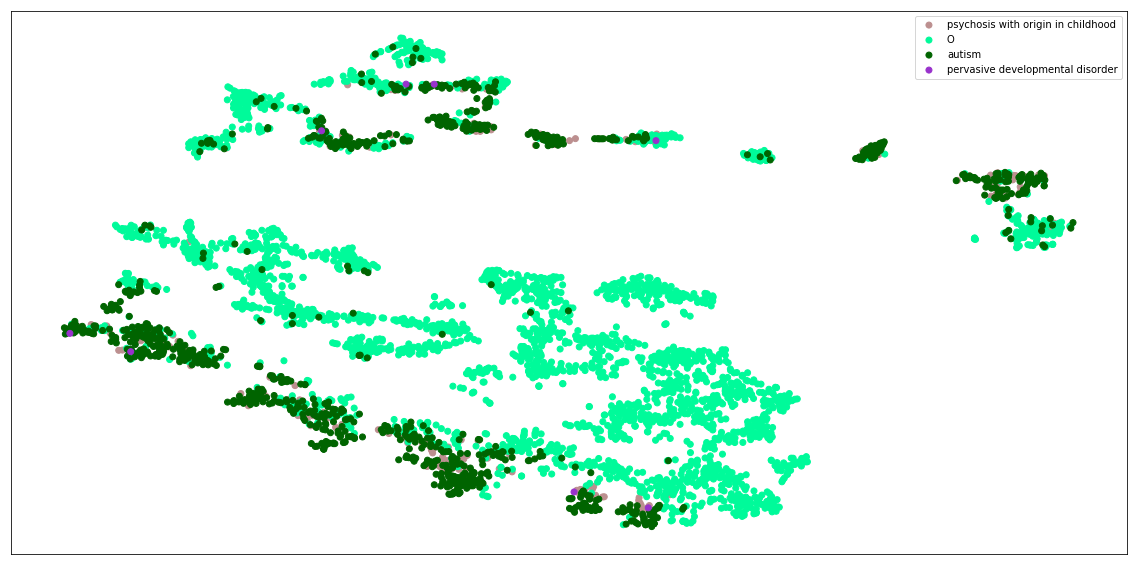

In [7]:
colors_lstmen1 = [colormap[disease_dict[v]] for v in lstm_mrn_encoded_disease]
single_plot(lstm_encoded_tsne, mrn_encoded_disease, colors_lstmen1)

In [8]:
#nonoverlap_plot(encoded_tsne, mrn_encoded_disease, colors_en1)

In [9]:
##Apply hierarchical clustering to encoded data
n_clust_lstmen, label_lstmen = hclust_ehr(lstm_encoded_vect, 9, 40, 'l1')

Number of clusters found:23, Silhouette score:0.195


### tSNE of the cluster found by hierarchical clusters

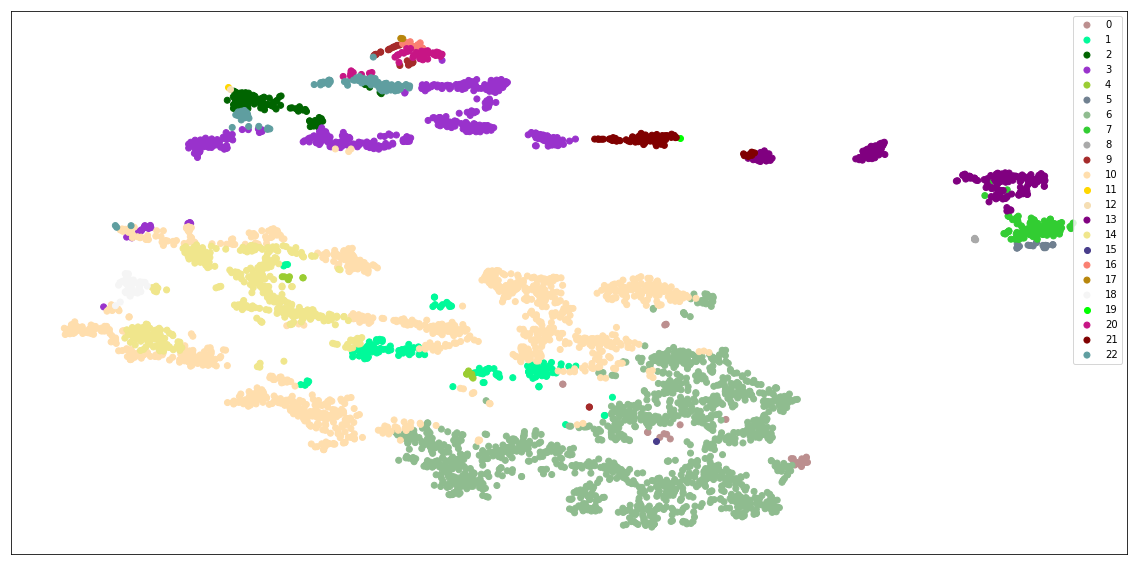

In [10]:
colors_lstmen2 = [colormap[v] for v in label_lstmen]
single_plot(lstm_encoded_tsne, label_lstmen, colors_lstmen2)

In [11]:
#nonoverlap_plot(encoded_tsne, label_en, colors_en2)

### Term frequencies inspection

In [12]:
freq_term(raw_data, n_clust_lstmen, label_lstmen, 10, ['icd9', 'medication'])

Cluster 0 numerosity: 27
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.01 (count 31)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.01 (count 23)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.00 (count 22)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Unspecified essential hypertension::401.9::C0085580 = 0.01 (count 20)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Impulse control disorder, unspecified::312.30::C0021122 = 0.03 (count 20)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Abnormality of gait::781.2::C0575081 = 0.04 (count 18)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Contracture of tendon (sheath)::727.81::C0158350 = 0.54 (count 14)
Cluster